# Simulating Random Isometries of the Poincare Disc

In [1]:
import cmath
from cmath import exp, log, phase, pi
import matplotlib.pyplot as plt
import numpy as np
from random import random as rand
import pandas as pd
import seaborn as sns

### Poincare disc
The Poincare disc $D^2$
is the unit disc (in the complex plane)
$\{z\in\mathbb C: |z|<1\}$
endowed with the so-called hyperbolic metric.

### Mobius transformation
A Mobius transformation is any function 
$z \mapsto \frac{az+b}{cz+d}$
where $a,b,c,d$ are (complex or real) constants
and $ad-bc\ne0$ (which ensures the function is one-to-one).
We often denote a Mobius transformation by its constants
using a 2-by-2 matrix
$(\begin{smallmatrix} a & b \\ c & d \end{smallmatrix})$,
but the representation is not unique,
since if you divide $a,b,c,d$ by the same number,
you end up with the same Mobius transformation.

### Isometries of the Poincare Disc
Mobius transformations that can be written
$$\begin{pmatrix} a & b\\ a\bar b & 1 \end{pmatrix},
    \quad \text{where}
    \quad |a|=1,
    \quad |b|<1
    $$
are very special.
- They preserve the Poincare disc $D^2$ abd its boundary circle $S^1$.
- They are isometries with respect to the Poincare disc's hyperbolic metric.
- They correspond to first rotating by the angle $\theta$ where $a = e^{i\theta}$,
and then translating so that $0\mapsto b$ (note that this is a translation in the *hyperbolic* metric; the picture to us looks like "sloshing" the interior of the disc over a bit).

We implement the class of Isometries of the Poincare Disc as ``D2Isom``.
An object in this class remembers two indentifying pieces of information
about itself:
- Its translation $t$, which is a complex number in the Poincare disc ($|t|<1$).
- Its rotation $r$, which is a real number between 0 (no rotation) and 1 (full 360 degree rotation).

On demand (print), the object can tell you its associated matrix
$(\begin{smallmatrix} a & b\\ a\bar b & 1 \end{smallmatrix})$,
which is computed by $a=e^{2\pi ir}$ and $b=t$.

In [2]:
# from cmath import exp, log, phase, pi
# from mpmath import exp, log, mpc, phase, pi

class D2Isom:
    def __init__(self, rotation=0, translation=0):
        self._r = rotation # real in [0,1)
        self._t = translation # complex number in unit disk
        # If you get error "object has no attribute ._tbar",
        # add your (exotic) number class to this tuple.
        if isinstance(translation, (complex,float,int)):
            self._tbar = translation.conjugate()
        elif isinstance(translation, mpc):
            self._tbar = mpmath.conjugate(translation)
    
    def __repr__(self):
        r = self._r
        t = self._t
        return f"D2Isom({r}, {t})"
    
    def _matrix(self):
        '''
        D2Isom(r,t) is the Mobius transformation:
        T = [a      t]
            [a*tbar 1]
        '''
        r = self._r
        t =  self._t
        tbar = self._tbar
        a = exp(1j*2*pi*r) # convert r in [0,1) to a in S1
        b = t
        c = tbar * a
        d = 1
        return [[a,b],[c,d]]
    
    def __str__(self):
        [[a,b],[c,d]] = self._matrix()
        return str(np.array([[a,b],[c,d]]))
    
    def __mul__(self, other):
        [[a1,b1],[c1,d1]] = self._matrix() # matrix T1
        [[a2,b2],[c2,d2]] = other._matrix() # matrix T2
        # matrix multiply T1 @ T2 = T3
        # then normalize so that d3 = 1;
        # we only need a,b to create new D2Isom
        a3 = (a1*a2 + b1*c2)/(b2*c1 + 1)
        b3 = (a1*b2 + b1)/(b2*c1 + 1)
        # convert a in S1 back to r in [0,1)
        r3 = phase(a3)/(2*pi)
        return D2Isom(r3, b3)
    
    def __call__(self, w):
        [[a,b],[c,d]] = self._matrix()
        return (a*w+b)/(c*w+d)
    
    def __pow__(self, n):
        result = D2Isom(0,0)
        while n>0:
            result = D2Isom.__mul__(self, result)
            n -= 1
        return result

# The Strip Map
The Strip Map sends the Poinare Disc $D^2$ to the biinfinite strip $\mathbb R\times(-1,1)$.
- The map fixes the points $-i, 0, i$.
- The map preserves the vertical diameter $[-i,i]$, 
but does not pointwise fix any points other than $-i, 0, i$.
- The map is conformal (angle preserving) but not an isometry.
- The map sends the horizontal diameter $[-1,1]$ to the real axis, 
sending $-1,0,1 \mapsto -\infty,0,\infty$ respectively.

The point of the Strip map is that the hyperbolic biinfinite geodesic $[-i,i]$.
gets mapped to the real line as a euclidean biinfinite geodesic $[-\infty, \infty]$,
and distances 
Hyperbolic distances along the real line are now pictured as actual euclidean distances.

In [3]:
def strip(z):
    z = (1 + z)/(1 - z)
    if isinstance(z, (complex,float,int)):
        z = 2/pi*np.log(z)
    elif isinstance(z, mpc):
        # np.log does not work with mpmath
        # must use log from mpmath or cmath
        z = 2/pi*log(z)
    return z

# Choosing random objects in the ``D2Isom`` class.
## Distribution $\mu_a$
This way of producing a random D2Isom object uses a uniform distribution on $D^2$ in the euclidean metric.
In other words, choose a random complex number $|z|<1$ according to the obvious way.

## Distribution $\mu_b$
This way of producing a random isometry uses a uniform distribution on euclidean distance from the point 0,
so that your euclidean distance from the point 0 is uniformly distributed between $[0,1]$.

In [4]:
def mu_a():
    '''
    Distribution #1.
    Choose a random t in unit disc (uniform).
    Choose a random r in [0,1) (uniform).
    Make D2Isom(r, t).
    '''
    try:
        one = mpc('1','0')
        one_i = mpc('0','1')
    except NameError:
        one = 1
        one_i = 1j
    r = rand()
    x = 2*rand() - one
    y = 2*rand() - one
    t = x + y * one_i
    try:
        fabs(t)
    except NameError:
        fabs = abs
    while fabs(t) >= one:
        x = 2*rand() - one
        y = 2*rand() - one
        t = x + y * one_i
    return D2Isom(r,t)


def mu_b():
    '''
    Distribution #b.
    Choose a random dist in [0,1) (uniform).
    Choose a random theta in [0,1) (uniform).
    Then make t = dist * exp(2j*pi*theta).
    Choose a random r in [0,1) (uniform).
    Make D2Isom(r, t).
    '''
    try:
        two_i = mpc('0','2')
    except NameError:
        two_i = 2j
    dist = rand()
    theta = rand()
    t = dist*exp(two_i*pi*theta)
    r = rand()
    return D2Isom(r,t)


def convolve(mu, n=1):
    '''
    Distribution mu, convolved with itself n times.
    '''
    result = mu()
    while n>1:
        result = result*mu()
        n -= 1
    return result

In [5]:
Ts1 = np.array([convolve(mu_b,1)(0) for _ in range(50000)])
Ts2 = np.array([convolve(mu_b,2)(0) for _ in range(50000)])
Ts5 = np.array([convolve(mu_b,5)(0) for _ in range(50000)])
Ts10 = np.array([convolve(mu_b,10)(0) for _ in range(50000)])

# https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.pyplot.scatter.html?highlight=scatter#matplotlib.pyplot.scatter
def myscatter(z):
    plt.scatter(z.real, z.imag, s=0.1, alpha=0.2)

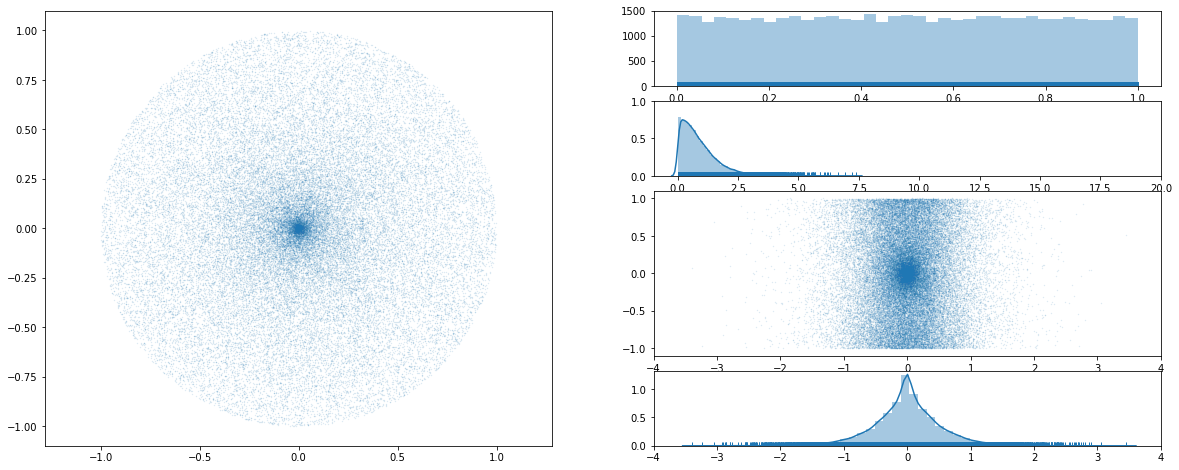

In [6]:
plt.figure(figsize=(20,8))

plt.subplot(5,2,(1,9))
plt.axis('equal')
myscatter(Ts1)

plt.subplot(5,2,2)
sns.distplot([abs(z) for z in Ts1], rug=True, kde=False)

plt.subplot(5,2,4)
plt.xlim(-1,20)
plt.ylim(0,1)
sns.distplot([strip(abs(z)) for z in Ts1], rug=True)

plt.subplot(5,2,(6,8))
plt.xlim(-4,4)
myscatter(np.array([strip(z) for z in Ts1]))

plt.subplot(5,2,10)
plt.xlim(-4,4)
sns.distplot([strip(z).real for z in Ts1], rug=True)

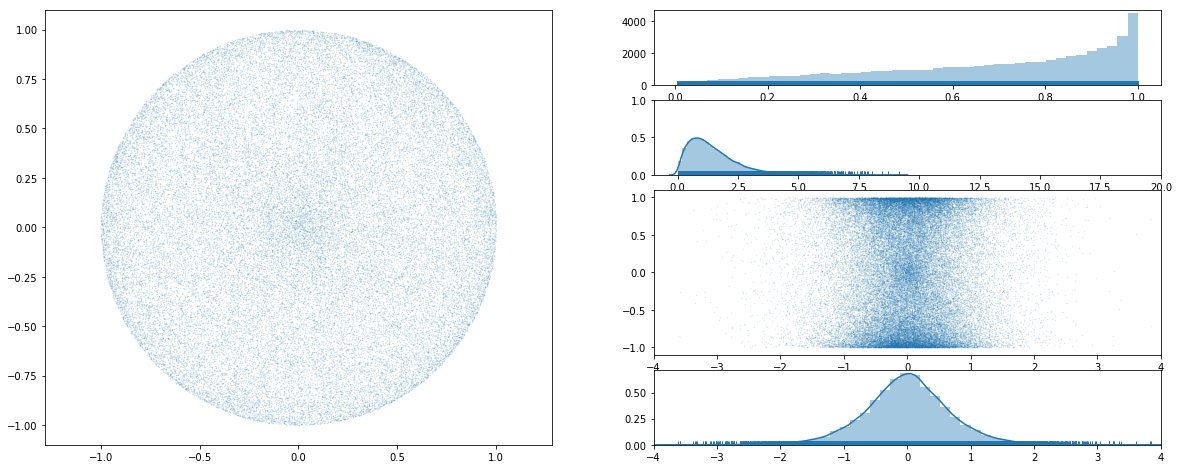

In [9]:
plt.figure(figsize=(20,8))

plt.subplot(5,2,(1,9))
plt.axis('equal')
myscatter(Ts2)

plt.subplot(5,2,2)
sns.distplot([abs(z) for z in Ts2], rug=True, kde=False)

plt.subplot(5,2,4)
plt.xlim(-1,20)
plt.ylim(0,1)
sns.distplot([strip(abs(z)) for z in Ts2], rug=True)

plt.subplot(5,2,(6,8))
plt.xlim(-4,4)
myscatter(np.array([strip(z) for z in Ts2]))

plt.subplot(5,2,10)
plt.xlim(-4,4)
sns.distplot([strip(z).real for z in Ts2], rug=True)

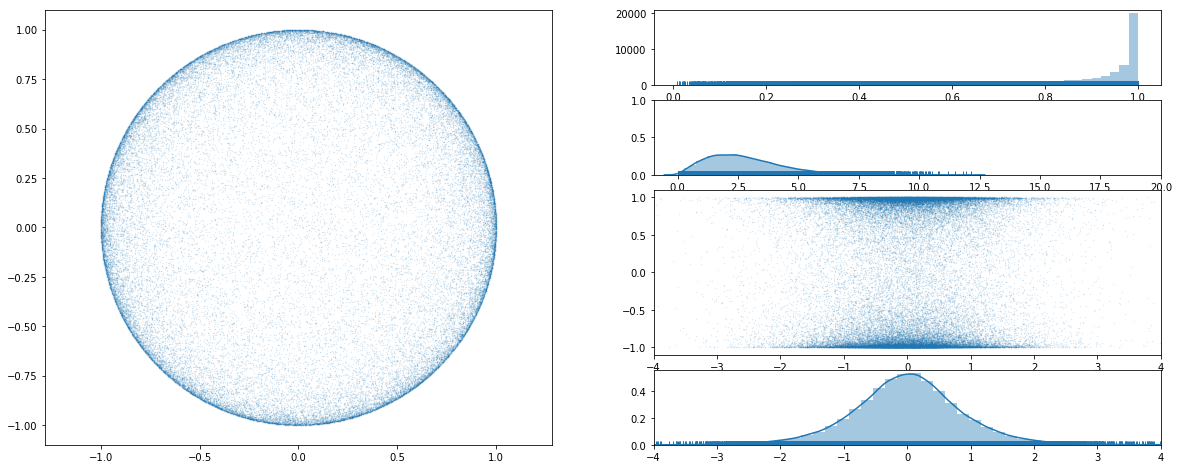

In [10]:
plt.figure(figsize=(20,8))

plt.subplot(5,2,(1,9))
plt.axis('equal')
myscatter(Ts5)

plt.subplot(5,2,2)
sns.distplot([abs(z) for z in Ts5], rug=True, kde=False)

plt.subplot(5,2,4)
plt.xlim(-1,20)
plt.ylim(0,1)
sns.distplot([strip(abs(z)) for z in Ts5], rug=True)

plt.subplot(5,2,(6,8))
plt.xlim(-4,4)
myscatter(np.array([strip(z) for z in Ts5]))

plt.subplot(5,2,10)
plt.xlim(-4,4)
sns.distplot([strip(z).real for z in Ts5], rug=True)

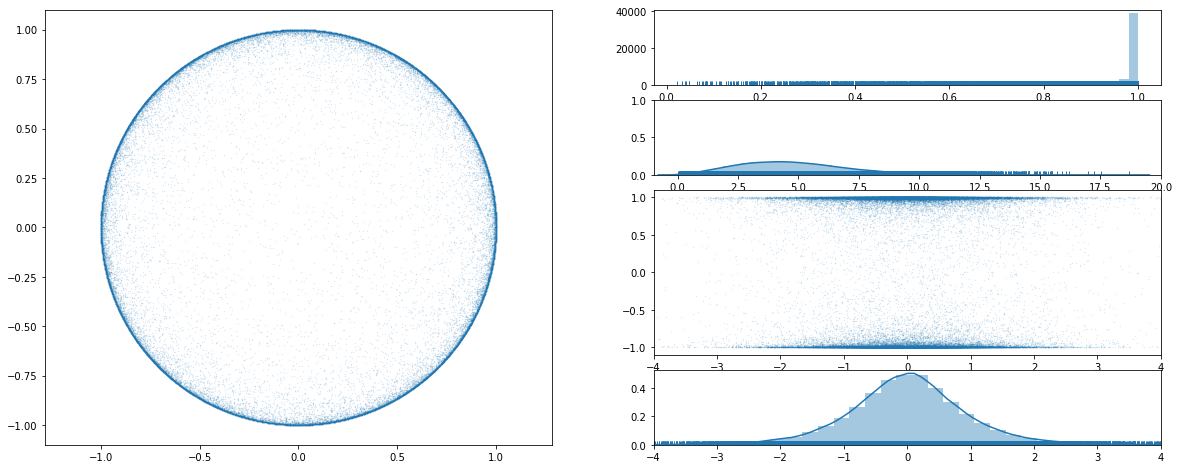

In [11]:
plt.figure(figsize=(20,8))

plt.subplot(5,2,(1,9))
plt.axis('equal')
myscatter(Ts10)

plt.subplot(5,2,2)
sns.distplot([abs(z) for z in Ts10], rug=True, kde=False)

plt.subplot(5,2,4)
plt.xlim(-1,20)
plt.ylim(0,1)
sns.distplot([strip(abs(z)) for z in Ts10], rug=True)

plt.subplot(5,2,(6,8))
plt.xlim(-4,4)
myscatter(np.array([strip(z) for z in Ts10]))

plt.subplot(5,2,10)
plt.xlim(-4,4)
sns.distplot([strip(z).real for z in Ts10], rug=True)

In [9]:
def make_plots(mu, n):
    pass